In [11]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F

In [12]:
run_id=359
qid=1603

In [19]:
stat = RunStats.objects.get(run_id=run_id)
print(stat.dthreshold)
dts = DocTopic.objects.filter(
    run_id=run_id,
    score__gt=stat.dthreshold
).values('topic__title')

dts = dts.annotate(
    ipcc = models.Sum(
        models.Case(
            models.When(doc__ipccref__isnull=False,then=1),default=0, output_field=models.FloatField()
        )
    ),
    no_ipcc = models.Sum(
        models.Case(
            models.When(doc__ipccref__isnull=True,then=1),default=0, output_field=models.FloatField()
        )
    )
)
df =  pd.DataFrame.from_dict(list(dts))

0.0014


In [16]:
df['total'] = df.ipcc+df.no_ipcc
df['ipcc_pcnt'] = df.ipcc/df.total*100
df = df.sort_values(by='ipcc_pcnt', ascending=0).reset_index(drop=True)
df.head()

,ipcc,no_ipcc,topic__title,total,ipcc_pcnt
0,106.0,2347.0,Climate change mitigation,2453.0,4.321239
1,96.0,2715.0,GHG emissions,2811.0,3.415155
2,41.0,1925.0,Air quality,1966.0,2.085453
3,71.0,3807.0,Urban form,3878.0,1.830841
4,62.0,3682.0,Energy efficiency & consumption,3744.0,1.655983


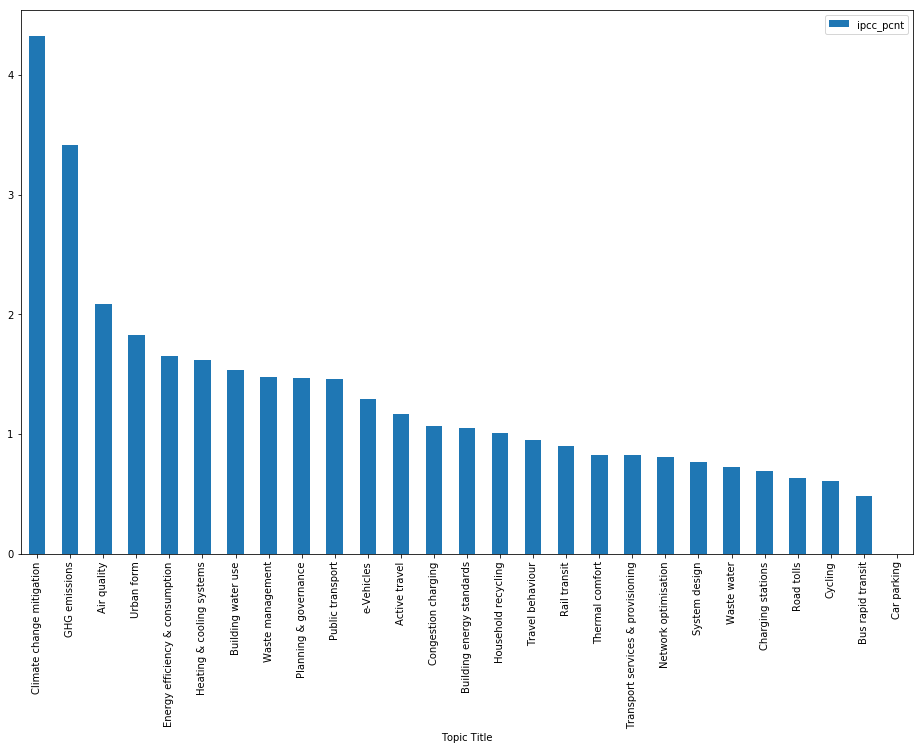

In [17]:
plt.rcParams["figure.figsize"] = [16,10]
bdf = df.set_index(['topic__title'])[['ipcc_pcnt']]
bdf.plot.bar();
plt.xlabel('Topic Title')
plt.savefig('../plots/ipcc_topics_{}.png'.format(run_id),bbox_inches='tight')   
plt.savefig('../plots/ipcc_topics_{}.svg'.format(run_id),bbox_inches='tight')   
plt.show()

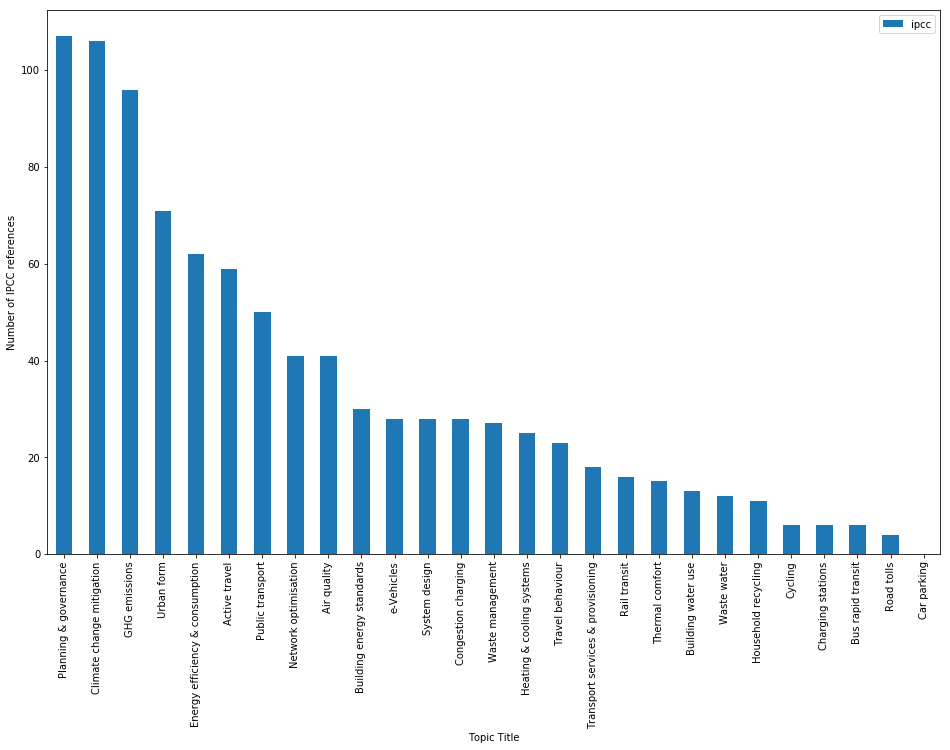

In [20]:
plt.rcParams["figure.figsize"] = [16,10]
bdf = df.set_index(['topic__title'])[['ipcc']].sort_values(by='ipcc', ascending=0)
bdf.plot.bar();
plt.xlabel('Topic Title')
plt.ylabel('Number of IPCC references')
plt.savefig('../plots/ipcc_topics_{}.png'.format(run_id),bbox_inches='tight')  
plt.savefig('../plots/ipcc_topics_{}.svg'.format(run_id),bbox_inches='tight')  
plt.show()

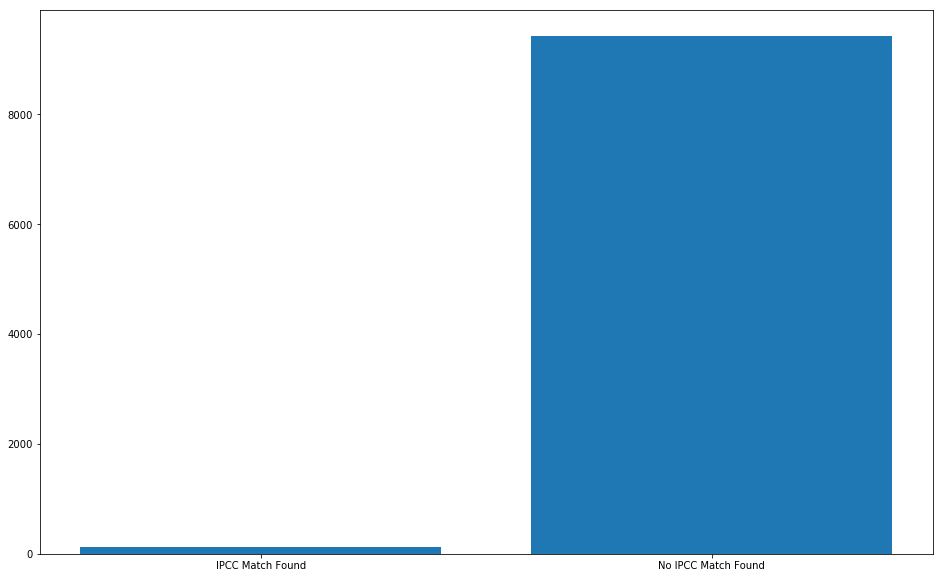

In [7]:
tdocs = Doc.objects.filter(query=qid)
ipdocs = tdocs.filter(ipccref__isnull=False).count()
nipdocs = tdocs.filter(ipccref__isnull=True).count()

ind = [1,2]

fig, ax = plt.subplots()

ax.bar(ind,[ipdocs,nipdocs])
ax.set_xticks(ind)
ax.set_xticklabels(["IPCC Match Found","No IPCC Match Found"])

plt.show()


In [8]:
ipdocs

129